In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import sem
from matplotlib.ticker import MultipleLocator

sns.set_style("ticks")
sns.despine()

def load_data(file_path):
    """Load the data from a parquet file."""
    try:
        return pd.read_parquet(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

def preprocess_data(df, time_col, activity_col, analyze_col):
    """Convert time to milliseconds and set relevant columns to NaN where 'analyze' is 0."""
    df['time_ms'] = df[time_col] * 1000
    df.loc[df[analyze_col] == 0, columns_to_nan] = np.nan
    return df

def normalize_activity(group, activity_col):
    """Normalize 'activity' for each trial."""
    lower_bound = group[activity_col].quantile(0.05)
    upper_bound = group[activity_col].quantile(0.95)
    range_ = upper_bound - lower_bound
    group['activity_normalized'] = (group[activity_col] - lower_bound) / range_
    return group

def find_transitions(df, state_1, state_2, trial_col, epoch_length, frame_rate):
    """Identify transitions and calculate epoch data and velocities."""
    transitions = []
    epoch_data = []
    epoch_indices = []
    epoch_velocities = []

    for i in range(1, len(df)):
        if df[state_1][i-1] == 1 and df[state_2][i] == 1:
            start_state = i - 1
            while start_state > 0 and df[state_1][start_state - 1] == 1:
                start_state -= 1

            end_state = i
            while end_state < len(df) - 1 and df[state_2][end_state + 1] == 1:
                end_state += 1

            # Check if the start and end of the epoch are in the same trial
            if df['trial'][start_state] == df['trial'][end_state]:
                if df['time_ms'][i-1] - df['time_ms'][start_state] > epoch_length and df['time_ms'][end_state] - df['time_ms'][i] > epoch_length:
                    transition_point = i
                    start_index = int(max(transition_point - frame_rate * epoch_length / 1000, 0))
                    end_index = int(min(transition_point + frame_rate * epoch_length / 1000, len(df)))

                    if end_index - start_index == 2 * frame_rate * epoch_length / 1000:
                        # Ensure that the entire epoch is within the same trial
                        if df['trial'][start_index] == df['trial'][end_index - 1]:
                            print(f"Epoch start index: {start_index}\n")
                            epoch = df.iloc[start_index:end_index]['activity_normalized']
                            epoch_data.append(epoch.values)
                            epoch_indices.append(len(epoch_data))  # Add epoch index
                            if state_1 == 'L1_walk':
                                epoch_velocity = df.iloc[start_index:transition_point]['vel_forward'].mean()
                            elif state_1 == 'L1_rest':
                                epoch_velocity = df.iloc[transition_point:end_index]['vel_forward'].mean()
                            else: print("Undefined State!")
                            epoch_velocities.append(epoch_velocity)  # Add epoch velocity

    return epoch_data, epoch_indices, epoch_velocities

def plot_activity(time_axis, average_trace, sem_trace, state_1, state_2):
    """Plot the average normalized activity."""
    plt.figure(figsize=(8, 6))

    x_min, x_max = np.min(time_axis), np.max(time_axis)
    plt.xlim(x_min, x_max)

    y_min = np.min(average_trace - sem_trace)
    y_max = np.max(average_trace + sem_trace)
    plt.ylim(y_min, y_max)

    plt.plot(time_axis, average_trace, color='blue', label='Average Activity', lw=1)
    plt.fill_between(time_axis, average_trace - sem_trace, average_trace + sem_trace, color='blue', alpha=0.2, label='SEM')
    if state_1 == 'Walking':
        plt.fill_betweenx(y=[average_trace.min()-sem_trace.max(), average_trace.max()+sem_trace.max()], x1=0, x2=np.min(time_axis), color='grey', alpha=0.2)
    elif state_1 == 'Resting':
        plt.fill_betweenx(y=[average_trace.min()-sem_trace.max(), average_trace.max()+sem_trace.max()], x1=0, x2=np.max(time_axis), color='grey', alpha=0.2)

    plt.xlabel('Time (s) relative to transition')
    plt.ylabel('Normalized Activity')
    plt.title(f'Average Normalized Activity with SEM Around {state_1} to {state_2} Transitions')
    plt.legend(frameon=False, loc = 'lower right')

    ax = plt.gca()  # Get the current Axes instance
    ax.yaxis.set_major_locator(MultipleLocator(base=0.1)) 
    ax.xaxis.set_major_locator(MultipleLocator(base=0.25))  

    sns.despine(offset=20, trim=False)
    plt.tight_layout()
    plt.show()

# Function to group epoch data based on velocity quantiles
def group_data_by_velocity(epoch_data, epoch_velocities, quantiles):
    groups = [[] for _ in range(len(quantiles) + 1)]
    for i, velocity in enumerate(epoch_velocities):
        for q_index, quantile in enumerate(quantiles):
            if velocity <= quantile:
                groups[q_index].append(epoch_data[i])
                break
        else:
            groups[-1].append(epoch_data[i])
    return groups

# Function for plotting each group
def plot_group(group, color, label):
    if group:
        average_trace = np.mean(np.array(group), axis=0)
        sem_trace = sem(np.array(group), axis=0)
        plt.plot(time_axis, average_trace, color=color, label=label, lw=2)
        plt.fill_between(time_axis, average_trace - sem_trace, average_trace + sem_trace, color=color, alpha=0.2)


<Figure size 640x480 with 0 Axes>

/var/folders/tz/5xxpw5x57bg8vtkdkhljt7880000gn/T/ipykernel_16833/3797559298.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df[state_1][i-1] == 1 and df[state_2][i] == 1:
/var/folders/tz/5xxpw5x57bg8vtkdkhljt7880000gn/T/ipykernel_16833/3797559298.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while start_state > 0 and df[state_1][start_state - 1] == 1:
/var/folders/tz/5xxpw5x57bg8vtkdkhljt7880000gn/T/ipykernel_16833/3797559298.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame be

Epoch start index: 1

Epoch start index: 1101

Epoch start index: 2394

Epoch start index: 10540

Epoch start index: 13086

Epoch start index: 15129

Epoch start index: 22367

Epoch start index: 25945

Epoch start index: 26490

Epoch start index: 29096

Epoch start index: 32954

Epoch start index: 42361

Epoch start index: 55612

Epoch start index: 57789

Epoch start index: 58380

Epoch start index: 78210

Epoch start index: 91323

Epoch start index: 95134

Epoch start index: 110056

Epoch start index: 112359

Epoch start index: 114191

Epoch start index: 120270

Epoch start index: 127587

Epoch start index: 135601

Epoch start index: 138408

Epoch start index: 141410

Epoch start index: 143058

Epoch start index: 144178

Epoch start index: 147505

Epoch start index: 149978

Epoch start index: 157216

Epoch start index: 160699

Epoch start index: 164692

Epoch start index: 169477

Epoch start index: 171006

Epoch start index: 171962

Epoch start index: 173834

Epoch start index: 175005

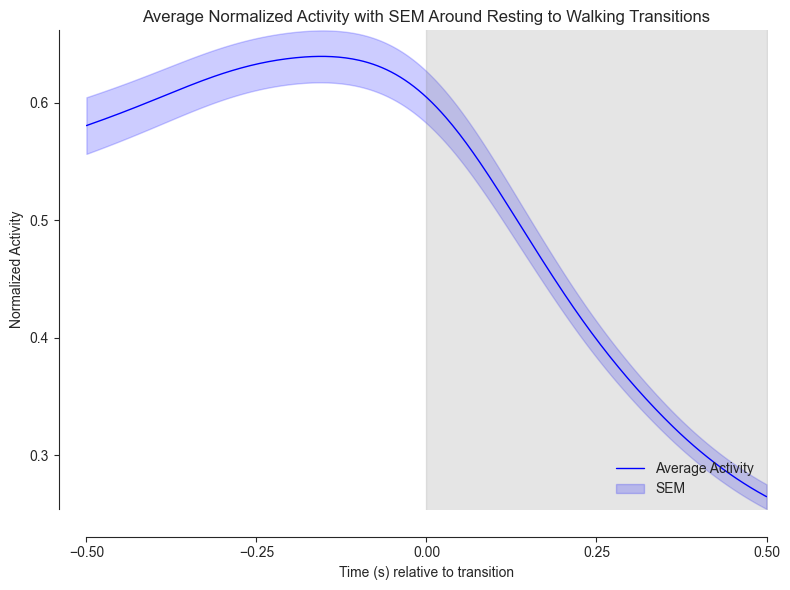

In [3]:
# Main execution: walk to rest transition.
file_path = '/Users/camellyc/Downloads/oval.parquet'
df = load_data(file_path)
if df is not None:
    columns_to_nan = ['activity_normalized', 'vel_forward', 'L1_rest', 'L1_walk']
    df = preprocess_data(df, 'time', 'activity', 'analyze')
    df = df.groupby('trial').apply(lambda group: normalize_activity(group, 'activity'))

    epoch_length = 500
    frame_rate = 300
    epoch_data, epoch_indices, epoch_velocities = find_transitions(df, 'L1_rest', 'L1_walk', 'trial', epoch_length, frame_rate)

    print(f"Number of epochs: {len(epoch_indices)}")
    print(f"Epoch velocities: {epoch_velocities}")

    average_trace = np.mean(np.array(epoch_data), axis=0)
    sem_trace = sem(np.array(epoch_data), axis=0)
    time_axis = np.linspace(-epoch_length/1000, epoch_length/1000, len(average_trace))
    plot_activity(time_axis, average_trace, sem_trace, 'Resting', 'Walking')

    output_df = pd.DataFrame({
    'x_time': time_axis,
    'x_average_signal': average_trace,
    'x_sem': sem_trace
    })
    output_df.to_excel('/Users/camellyc/Downloads/oval_RtoW.xlsx', index=False)

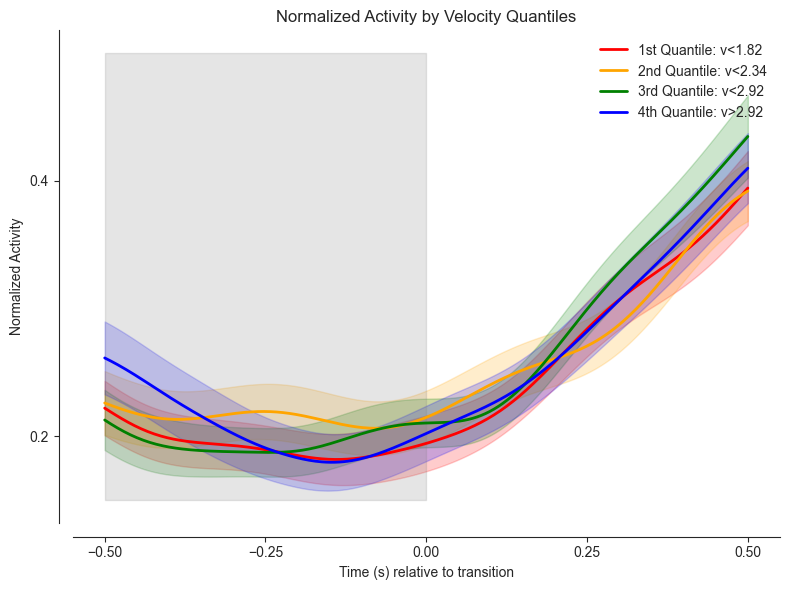

In [19]:
# Sorting epochs based on velocities
sorted_indices = np.argsort(epoch_velocities)
sorted_epoch_data = [epoch_data[i] for i in sorted_indices]
sorted_velocities = [epoch_velocities[i] for i in sorted_indices]

# Determining quantiles of velocities
quantiles = np.percentile(sorted_velocities, [25, 50, 75])

# Splitting data into groups based on quantiles
groups = group_data_by_velocity(sorted_epoch_data, sorted_velocities, quantiles)

# Plotting each group
plt.figure(figsize=(8, 6))

quantile_labels = ['1st Quantile', '2nd Quantile', '3rd Quantile', '4th Quantile']
colors = ['red', 'orange', 'green', 'blue']
for i, group in enumerate(groups):
    label = f'{quantile_labels[i]}: v<{quantiles[i]:.2f}' if i < len(quantiles) else f'{quantile_labels[i]}: v>{quantiles[-1]:.2f}'
    plot_group(group, colors[i], label)

# Coloring regions where x > 0 grey
sns.despine(offset=10, trim = False)
plt.fill_betweenx(y=[0.15, 0.50], x1=0, x2=np.min(time_axis), color='grey', alpha=0.2)
plt.xlabel('Time (s) relative to transition')
plt.ylabel('Normalized Activity')
plt.title('Normalized Activity by Velocity Quantiles')
plt.legend(frameon=False)

ax = plt.gca()  # Get the current Axes instance
ax.yaxis.set_major_locator(MultipleLocator(base=0.2)) 
ax.xaxis.set_major_locator(MultipleLocator(base=0.25)) 

plt.tight_layout()
plt.show()


/var/folders/tz/5xxpw5x57bg8vtkdkhljt7880000gn/T/ipykernel_16833/3797559298.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df[state_1][i-1] == 1 and df[state_2][i] == 1:
/var/folders/tz/5xxpw5x57bg8vtkdkhljt7880000gn/T/ipykernel_16833/3797559298.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while start_state > 0 and df[state_1][start_state - 1] == 1:
/var/folders/tz/5xxpw5x57bg8vtkdkhljt7880000gn/T/ipykernel_16833/3797559298.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame be

Epoch start index: 300

Epoch start index: 2037

Epoch start index: 7311

Epoch start index: 10695

Epoch start index: 13303

Epoch start index: 18329

Epoch start index: 26145

Epoch start index: 40329

Epoch start index: 42557

Epoch start index: 51356

Epoch start index: 56467

Epoch start index: 76657

Epoch start index: 110310

Epoch start index: 112547

Epoch start index: 131809

Epoch start index: 138241

Epoch start index: 138754

Epoch start index: 144394

Epoch start index: 146274

Epoch start index: 152425

Epoch start index: 156993

Epoch start index: 157369

Epoch start index: 158952

Epoch start index: 160483

Epoch start index: 171173

Epoch start index: 173233

Epoch start index: 174839

Epoch start index: 179472

Epoch start index: 185027

Epoch start index: 185465

Epoch start index: 186300

Epoch start index: 202133

Epoch start index: 203025

Epoch start index: 206865

Epoch start index: 210106

Epoch start index: 210652

Epoch start index: 216211

Epoch start index

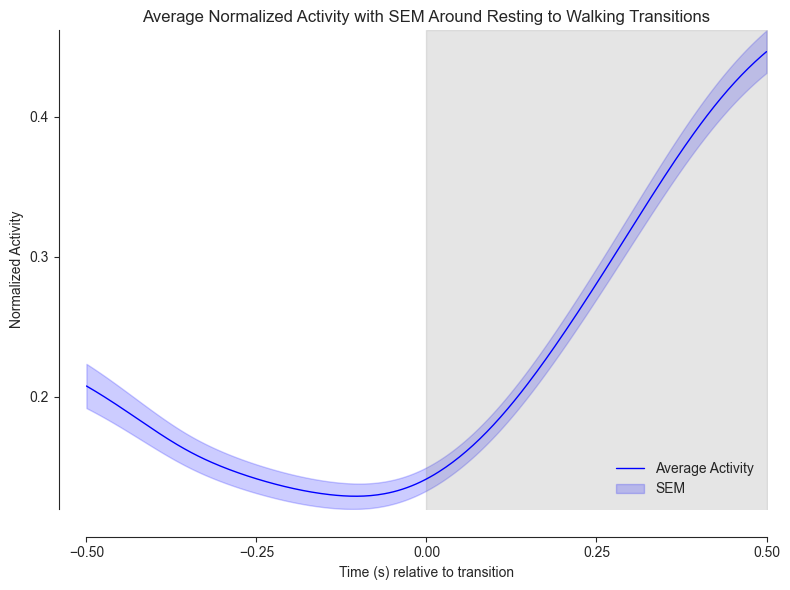

In [10]:
# Main execution
file_path = '/Users/camellyc/Downloads/oval.parquet'
df = load_data(file_path)
if df is not None:
    columns_to_nan = ['activity_normalized', 'vel_forward', 'L1_walk', 'L1_rest']
    df = preprocess_data(df, 'time', 'activity', 'analyze')
    df = df.groupby('trial').apply(lambda group: normalize_activity(group, 'activity'))

    epoch_length = 500
    frame_rate = 300
    epoch_data, epoch_indices, epoch_velocities = find_transitions(df, 'L1_walk', 'L1_rest', 'trial', epoch_length, frame_rate)

    print(f"Number of epochs: {len(epoch_indices)}")
    print(f"Epoch velocities: {epoch_velocities}")

    average_trace = np.mean(np.array(epoch_data), axis=0)
    sem_trace = sem(np.array(epoch_data), axis=0)
    time_axis = np.linspace(-epoch_length/1000, epoch_length/1000, len(average_trace))
    plot_activity(time_axis, average_trace, sem_trace, 'Resting', 'Walking')
    output_df = pd.DataFrame({
    'x_time': time_axis,
    'x_average_signal': average_trace,
    'x_sem': sem_trace
    })
    output_df.to_excel('/Users/camellyc/Downloads/oval_WtoR.xlsx', index=False)

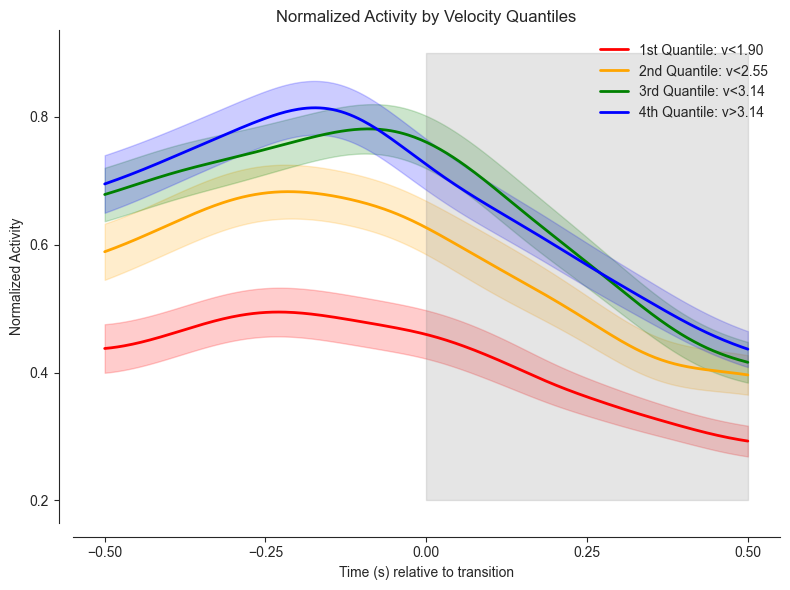

In [21]:
# Sorting epochs based on velocities
sorted_indices = np.argsort(epoch_velocities)
sorted_epoch_data = [epoch_data[i] for i in sorted_indices]
sorted_velocities = [epoch_velocities[i] for i in sorted_indices]

# Determining quantiles of velocities
quantiles = np.percentile(sorted_velocities, [25, 50, 75])

# Splitting data into groups based on quantiles
groups = group_data_by_velocity(sorted_epoch_data, sorted_velocities, quantiles)

# Plotting each group
plt.figure(figsize=(8, 6))

quantile_labels = ['1st Quantile', '2nd Quantile', '3rd Quantile', '4th Quantile']
colors = ['red', 'orange', 'green', 'blue']
for i, group in enumerate(groups):
    label = f'{quantile_labels[i]}: v<{quantiles[i]:.2f}' if i < len(quantiles) else f'{quantile_labels[i]}: v>{quantiles[-1]:.2f}'
    plot_group(group, colors[i], label)

# Coloring regions where x > 0 grey
sns.despine(offset=10, trim = False)
plt.fill_betweenx(y=[0.2, 0.9], x1=0, x2=np.max(time_axis), color='grey', alpha=0.2)
plt.xlabel('Time (s) relative to transition')
plt.ylabel('Normalized Activity')
plt.title('Normalized Activity by Velocity Quantiles')
plt.legend(frameon=False)

ax = plt.gca()  # Get the current Axes instance
ax.yaxis.set_major_locator(MultipleLocator(base=0.2)) 
ax.xaxis.set_major_locator(MultipleLocator(base=0.25)) 

plt.tight_layout()
plt.show()
